# Problem 1

You have been provided with two image files: a newspaper clipping and a microscopic image of a snowflake.

a. Try to enhance these images using filters in the spatial domain. Show the results for both blurring and sharpening filters. Also show a final image of your best enhancement using a single filter or a combination of multiple filters.

b. Try to enhance these image using filters in the frequency domain. Show the results for both high-pass and low-pass filters. Also show a final image of your best enhancement using a single filter or a combination of multiple filters.

c. Using one of the above workflows, turn your code into a function that you could potentially re-use for future analyses.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from skimage.morphology import square, disk
from skimage.filters import laplace, rank
from skimage.color import rgb2gray
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
#from skimage.exposure import equalize_hist
#from mpl_toolkits.mplot3d import Axes3D

In [2]:
#acess the images
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
crystal = plt.imread('/content/drive/MyDrive/hw3_crystal.jpeg')
newspaper = plt.imread('/content/drive/MyDrive/hw3_newspaper.jpeg')

In [4]:
#Make the images easily workable

#crystal image needs to be in grayscale
im_cr = rgb2gray(crystal)

#newspaper image has a weird glitch so lets fix that
im_np = img_as_ubyte(img_as_float(newspaper))


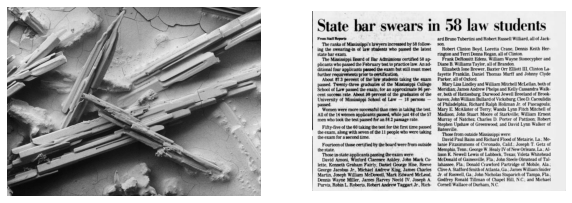

In [5]:
#Check the images
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

ax[0].imshow(im_cr, cmap='gray')
ax[1].imshow(im_np, cmap='gray')

for axi in ax:
  axi.axis('off')

**Lets test some filters in the spatial domain.**

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


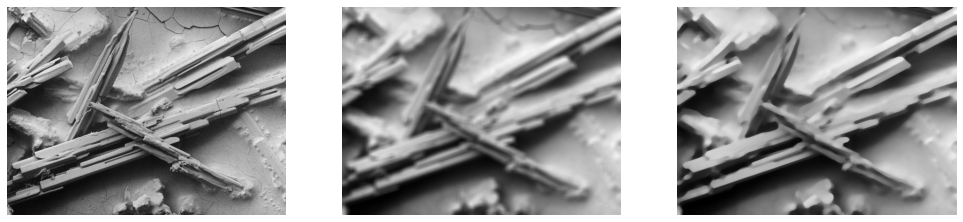

In [6]:
#For blurring the image, lets look at at a mean filter and a median filter using both a square structuring element
# Note: median ignores outliers but maintains edges
selem = square(15)
#selem = disk(7) #Could also try a disk filter

#test using im_cr
mean_cr = rank.mean(im_cr, selem=selem)
med_cr = rank.median(im_cr, selem=selem)

#Compare the mean and the median to the original grayscale crystal image
fig, ax = plt.subplots(ncols=3, figsize=(17,6))

ax[0].imshow(im_cr,cmap='gray')
ax[1].imshow(mean_cr, cmap='gray')
ax[2].imshow(med_cr, cmap='gray')
for axi in ax:
  axi.axis('off')

I like that the median still provides some detail. Now lets do the same for the newspaper:

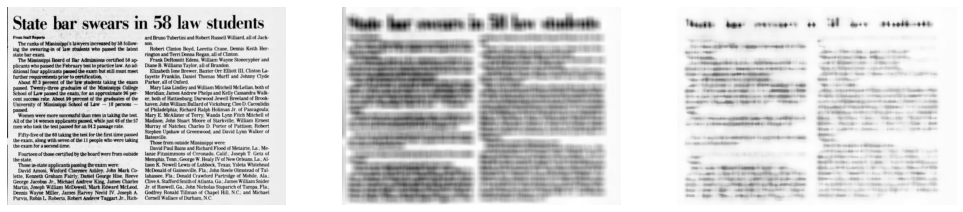

In [7]:
#test using im_np
mean_np = rank.mean(im_np, selem=selem)
med_np = rank.median(im_np, selem=selem)

#Compare the mean and the median to the original grayscale crystal image
fig, ax = plt.subplots(ncols=3, figsize=(17,6))

ax[0].imshow(im_np,cmap='gray')
ax[1].imshow(mean_np, cmap='gray')
ax[2].imshow(med_np, cmap='gray')
for axi in ax:
  axi.axis('off')

(-0.5, 545.5, 387.5, -0.5)

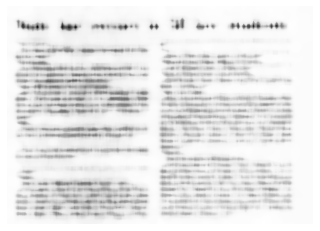

In [8]:
#best blur: 
plt.imshow(med_np, cmap='gray')
plt.axis('off')

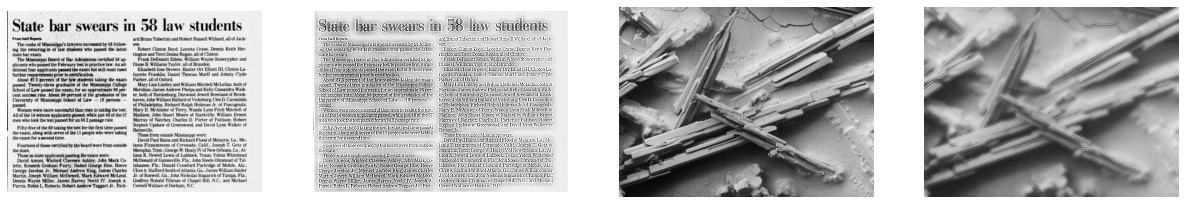

In [21]:
#for sharpening filters, lets make a Laplacian filter
#Note: a difference of gaussians would be similar to applying the LaPlacian

#the laPlacian uses differentials to enhances edges and other discontinuities
#lets test it on the newspaper image
np_lap = laplace(im_np,ksize=3)
np_meanf = img_as_float(rank.mean(im_np,selem=square(20)))
np_sharp = np_meanf + np_lap

#lets do this for the crystal image as well
cr_lap = laplace(im_cr,ksize=3)
cr_meanf = img_as_float(mean_cr)
cr_sharp = cr_meanf + cr_lap

fig, ax = plt.subplots(ncols=4, figsize=(21,5))
for axi in ax:
  axi.axis('off')

ax[0].imshow(im_np, cmap='gray')
ax[1].imshow(np_sharp, cmap='gray', vmin=0,vmax=1)  #sharpen again
ax[2].imshow(im_cr, cmap='gray')
ax[3].imshow(cr_sharp, cmap='gray', vmin=0, vmax=1)

The crystal image is sharper but the newspaper didn't get better even when drastically increasing selem

**Now lets use filters in the frequency domain. high-pass filters attenuate low frequencies while "passing" high frequencies. This leaves less gray-level variations in smooth areas and ephasises edges, sharpening the image. Meanwhile, a low-pass filter does the opposite, blurring the image.** 

In [10]:
#need the size of what we are filtering. Lets use the crystal first
im_cr.shape

(596, 799)

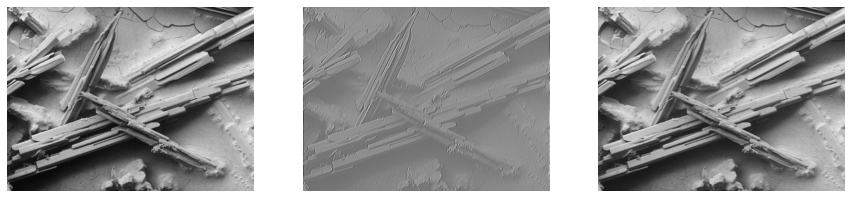

In [11]:
#A low-pass filter will blur the image
xi = np.linspace(0,798,799)
yi = np.linspace(0,595,596)
x,y = np.meshgrid(xi,yi)
mu, sigma = 256, 59 #change sigma to increase/decrease filter

#create a low-pass filter
lp_filt =np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2)) # inverse will remove the low freq 

#create the low-pass filtered image
f_im = sp.fft.fft2(im_cr) #perform FFT
f_im2 = sp.fft.fftshift(f_im) #center
f_im3 = np.multiply(f_im2, lp_filt) #Multiply by filter function
f_im4 = sp.fft.ifftshift(f_im3) #uncenter
im2 = np.real(sp.fft.ifft2(f_im4)) #perform iFFT

mu, sigma = 256, 100 #want these different for the high-pass
#create a high-pass filter
hp_filt = 1 - np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2)) # inverse will remove the low freq 

#create the high-pass filtered image 
#f_im = sp.fft.fft2(im) #perform FFT if I hadn't already done so above
f_im2b = sp.fft.fftshift(f_im) #center
f_im3b = np.multiply(f_im2b, hp_filt) #Multiply by filter function
f_im4b = sp.fft.ifftshift(f_im3b) #uncenter
im3 = np.real(sp.fft.ifft2(f_im4b)) #perform iFFT



#compare all three to the origional
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(im_cr,cmap='gray')
ax[1].imshow(im2, cmap='gray')
ax[2].imshow(im3, cmap='gray')

for axi in ax:
  axi.axis('off')

In [12]:
#Make a function that creates a filter
def make_hp_filt(length,width,mu,sigma):
  #given length and width of an image and values for mu and sigma
  #create a high pass filter
  xi = np.linspace(0,width-1,width)
  yi = np.linspace(0,length-1,length)
  x,y = np.meshgrid(xi,yi)
  filter = 1 - np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2))
  return filter

def make_lp_filt(length,width,mu,sigma):
  #given length and width of an image and values for mu and sigma
  #create a low pass filter
  xi = np.linspace(0,width-1,width)
  yi = np.linspace(0,length-1,length)
  x,y = np.meshgrid(xi,yi)
  filter = np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2))
  return filter

In [13]:
#Lets make a function to use a frequency domain filter
def freq_filt(im,filt):
  #given an image (im) and a filter (filt)
  f_im = sp.fft.fft2(im) #perform FFT
  f_im2 = sp.fft.fftshift(f_im) #center
  f_im3 = np.multiply(f_im2, filt) #Multiply by filter function
  f_im4 = sp.fft.ifftshift(f_im3) #uncenter
  im2 = np.real(sp.fft.ifft2(f_im4)) #perform iFFT
  return im2
  

#add finding the height and width of the image using w,h = im.shape if I have time


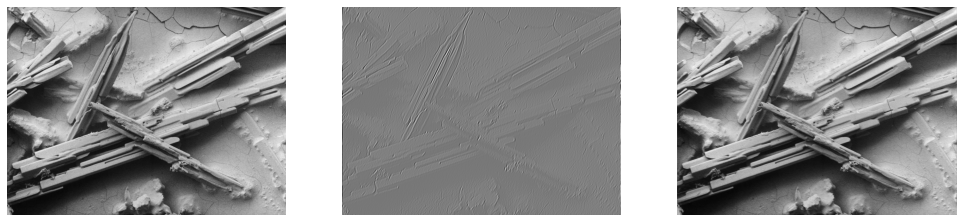

In [14]:
#test our filter:
w = 799
l = 596
mu, sigma = 256, 49
lp_filter = make_lp_filt(l,w,mu,sigma)
cr_blur = freq_filt(im_cr,lp_filter)

hp_filter = make_hp_filt(l,w,mu,sigma)
cr_shar = freq_filt(im_cr,hp_filter)

fig, ax = plt.subplots(ncols=3, figsize=(17,5))
for axi in ax:
  axi.axis('off')

ax[0].imshow(im_cr, cmap='gray')
ax[1].imshow(cr_blur, cmap='gray')  #sharpen again
ax[2].imshow(cr_shar, cmap='gray')



Great, that is so much nicer... lets use the functions on the newspaper now

In [15]:
im_np.shape

(388, 546)

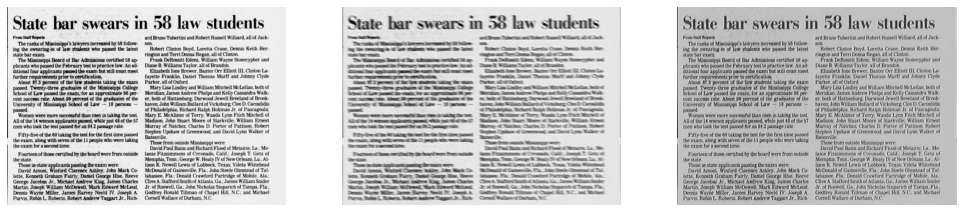

In [16]:
w = 546
l = 388
mu, sigma = 256, 49
lp_filter = make_lp_filt(l,w,mu,sigma)
np_blur = freq_filt(im_np,lp_filter)
mu, sigma = 256, 49
hp_filter = make_hp_filt(l,w,mu,sigma)
np_shar = freq_filt(im_np,hp_filter)

fig, ax = plt.subplots(ncols=3, figsize=(17,5))
for axi in ax:
  axi.axis('off')

ax[0].imshow(im_np, cmap='gray')
ax[1].imshow(np_blur, cmap='gray')  #sharpen again
ax[2].imshow(np_shar, cmap='gray')

**Overall the laplacian did a better job of sharpening both images. The sharpest image was:**

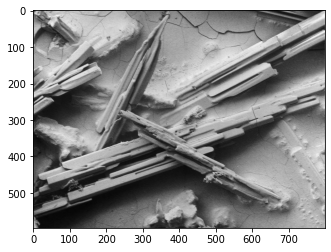

In [24]:
plt.imshow(cr_shar, cmap='gray')

# Problem 2

a. Demo one of your early functions for your project here. Each team member should use a different function. This should include written documentation in Markdown for each of the steps. Think of it as a tutorial for your function. Explain the inputs and the outputs. The function should include a number of inputs to modify the behavior of the function.

b. Write up some documentation for your function using the [Numpy docstrings guide](https://numpydoc.readthedocs.io/en/latest/format.html) for appropriate formatting. At a minimum, this should include the Short Summary, Extended Summary, Parameters, Returns, and Examples sections. MAke sure to add your final function to a `.py` file within your repo.

In [28]:
def binarize(im, turn):
  """
  Binarizes a given image
  """

In [ ]:
"""
This function takes an image and binarizes it based on a given turning point. 
Pixels with a value above the given turning point are set equal to 1 (white),
while pixels equal to or below the turning point are set equal to 0 (black). 
If the pixel values are greater than 1, the function will throw an error message.
"""

In [ ]:
Parameters
----------
im  : 2D int array
      image
turn: int
      integer between 0 and 1
      pixel values above "turn" are set equal to 1
      pixel values equal to or below "turn" are set equal to 0


In [ ]:
Returns
-------
err_code  : str
            prints error message if pixel value is greater than 1
binary_im : 2D int array
            binarized version of image im

In [43]:
def binarize(im, turn):
  w, h = im.shape
  binary_im = np.zeros((w,h)) 
  error_code = 'Error: pixel values must be between 0 and 1'

  for a,i in enumerate(im):
    for b,j in enumerate(i):
      if j>1:
        print(error_code)
      if j>turn:
        binary_im[a,b]=1
  return binary_im

In [48]:
Example
--------
#import urllib2
#file = urllib2.urlopen("https://www.pbs.org/wnet/nature/files/2016/10/mezzanine_904.jpg")
#im = plt.imread(file)
#im = rgb2gray(im)

>>> binarize(im, 0.25)
binary_im

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])